<b>Name</b> : Sindhura Bagodu Ramachandra

<b>USC ID</b> : 4628596426

<b>Github username</b> : SindhuraBagodu

In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn import metrics
import warnings
import random
import os
import shutil
import math
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import vgg16
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential 
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.applications.inception_v3 import preprocess_input

##### 1. Transfer Learning for Image Classification1

It is highly recommended that you complete this project using Keras2 and Python.

(a) In this problem, we are trying to build a classifier that distinguishes images of 20 bird species. You are provided with text data in twenty folders.

###### (b) Data Exploration and Pre-processing

i. Images in each class are given in separate folders. The file Classes.xlsx provides the classes assigned to the bird species images in each folder. Therefore, you encode your classes using one-hot encoding and Classes.xlsx.

ii. Randomly select d0.7ni images from each folder as your training set, [0.15ni] as validation set, and the rest as your test set, where ni is the number of images in folder i and dxe is the ceiling of x. 


In [44]:
try:
    os.makedirs('./output')
    os.makedirs('./output/train')
    os.makedirs('./output/test')

    os.listdir('./output')
    
except OSError as e:
    print(e)


In [45]:
from logging import exception
root_dir = '../Data/images'
classes = ['005.Crested_Auklet', '013.Bobolink', '015.Lazuli_Bunting', '023.Brandt_Cormorant', '040.Olive_sided_Flycatcher', '041.Scissor_tailed_Flycatcher', '067.Anna_Hummingbird', '072.Pomarine_Jaeger', '076.Dark_eyed_Junco', '081.Pied_Kingfisher', '082.Ringed_Kingfisher', '086.Pacific_Loon', '099.Ovenbird', '104.American_Pipit', '127.Savannah_Sparrow', '135.Bank_Swallow', '141.Artic_Tern', '149.Brown_Thrasher', '156.White_eyed_Vireo', '168.Kentucky_Warbler']

for clss in classes:
    dirtry = root_dir + '/' + clss
    files = os.listdir(dirtry)
    np.random.shuffle(files)
    
    base_outdir = './output/'

    for folder in ['train', 'validation','test']:
        target_dir = base_outdir + folder
        try:
            os.makedirs(target_dir + '/' + clss)
        except OSError as e:
            print(e)
        target_class = target_dir + '/' + clss

        if folder == 'train':
            images_to_pass = files[: math.ceil(0.7*len(files))]
            for img in images_to_pass:
                img = dirtry + '/' + img
                try:                  
                    shutil.copy(img, target_class)
                except OSError as e:
                    print(e)

        elif folder == 'validation':
            images_to_pass = files[math.ceil(0.7*len(files)): math.ceil(0.85*len(files))]
            for img in images_to_pass:
                img = dirtry + '/' + img
                try:
                    shutil.copy(img, target_class)
                except OSError as e:
                      print(e)

        else:
            images_to_pass = files[math.ceil(0.85*len(files)):]
            for img in images_to_pass:
                img = dirtry + '/' + img
                try:
                    shutil.copy(img, target_class)
                except OSError as e:
                    print(e)




iii. In order for all the images to have the same size, zero-pad or resize the images in your dataset. This can be done using various tools, including OpenCV.

In [46]:
classes = ['005.Crested_Auklet', '013.Bobolink', '015.Lazuli_Bunting', '023.Brandt_Cormorant', '040.Olive_sided_Flycatcher', '041.Scissor_tailed_Flycatcher', '067.Anna_Hummingbird', '072.Pomarine_Jaeger', '076.Dark_eyed_Junco', '081.Pied_Kingfisher', '082.Ringed_Kingfisher', '086.Pacific_Loon', '099.Ovenbird', '104.American_Pipit', '127.Savannah_Sparrow', '135.Bank_Swallow', '141.Artic_Tern', '149.Brown_Thrasher', '156.White_eyed_Vireo', '168.Kentucky_Warbler']
def resize(path):
    
    for clss in classes:
        dirtry = path + '/' + clss
        files = os.listdir(dirtry)
        for item in files:
            f_img = dirtry+"/"+item
            img = Image.open(f_img)
            img = img.resize((224,224))
            img.save(f_img)           


resize('./output/train/')
resize('./output/validation/')
resize('./output/test/')

##### (c) Transfer Learning

i. When dealing with classification of relatively small image datasets, deep networks may not perform very well because of not having enough data to train them. In such cases, one usually uses transfer learning, which uses deep learning models that are trained on very large datasets such as ImageNet as feature extractors. The idea is that such deep networks have learned to extract meaningful features from an image using their layers, and those features can be used in learning other tasks. In order to do that, usually the last layer or the last few layers of the pre-trained network are removed, and the response of the layer before the removed layers to the images in the new dataset is used as a feature vector to train one more multiple replacement layers. The dataset in this task has only around 50-60 images per class. Given that we have 20 classes, training a deep network with such a small dataset may not yield desirable results. In this project, you will use pre-trained models EfficientNetB0 and VGG16. For both pre-trained networks, you will only train the last fully connected layer, and will freeze all layers before them (i.e. we do not change their parameters during training) and use the outputs of the penultimate layer in the original pre-trained model as the features extracted from each image.

ii. To perform empirical regularization, crop, randomly zoo, rotate, flip, contrast, and translate images in your training set for image augmentation. You can use various tools to do this, including OpenCV. 

iii. Use ReLU activation functions in the last layer and a softmax layer, along with batch normalization 4 and a dropout rate of 20% as well as ADAM optimizer. Use multinomial cross entropy loss. You can try any batch size, but a batch size of 5 seems reasonable.

iv. Train the networks (EfficientNetB0 and VGG16) for at least 50 epochs (preferably 100 epochs) and perform early stopping using the validation set. Keep the network parameters that have the lowest validation error. Plot the training and validation errors vs. epochs.

v. Report Precision, Recall, and F1 score for your model. Remember that this
is a multi-class classification problem.

#### VGG16

In [54]:
classes_label = ['005.Crested_Auklet', '013.Bobolink', '015.Lazuli_Bunting', '023.Brandt_Cormorant', '040.Olive_sided_Flycatcher', '041.Scissor_tailed_Flycatcher', '067.Anna_Hummingbird', '072.Pomarine_Jaeger', '076.Dark_eyed_Junco', '081.Pied_Kingfisher', '082.Ringed_Kingfisher', '086.Pacific_Loon', '099.Ovenbird', '104.American_Pipit', '127.Savannah_Sparrow', '135.Bank_Swallow', '141.Artic_Tern', '149.Brown_Thrasher', '156.White_eyed_Vireo', '168.Kentucky_Warbler']

def random_crop(np_tensor):
    new_height = int(np.random.uniform(0.7, 1.30) * np_tensor.shape[0])

    new_width = int(np.random.uniform(0.7, 1.30) * np_tensor.shape[1])

    cropped = tf.image.resize_with_crop_or_pad(np_tensor, new_height, new_width)

    return tf.image.resize(cropped, np_tensor.shape[:2])

train_datagen = ImageDataGenerator(rotation_range=30, horizontal_flip=True, brightness_range=[0.1, 0.7], width_shift_range=0.5, preprocessing_function= tf.keras.applications.vgg16.preprocess_input)
train_generator = train_datagen.flow_from_directory('./output/train', target_size=(224,224), batch_size=5,classes=classes_label, class_mode='categorical', shuffle=True)

valid_datagen = ImageDataGenerator(rotation_range=30, horizontal_flip=True, brightness_range=[0.1, 0.7], width_shift_range=0.5,preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
valid_generator = valid_datagen.flow_from_directory('./output/validation',target_size=(224,224),batch_size=5,classes=classes_label,class_mode='categorical',shuffle=False)

test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
test_generator = test_datagen.flow_from_directory('./output/test',target_size=(224,224),batch_size=5,classes=classes_label,class_mode='categorical',shuffle=False)


Found 827 images belonging to 20 classes.
Found 178 images belonging to 20 classes.
Found 171 images belonging to 20 classes.


In [50]:
train_y=train_generator.classes
test_y=test_generator.classes
val_y=valid_generator.classes

In [51]:
vgg16_model = vgg16.VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = keras.Sequential()

for layer in vgg16_model.layers[:-1]:
    model.add(layer)    

for layer in model.layers:
    layer.trainable = False

model.add(tf.keras.layers.Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(20, activation='softmax'))
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc', 'MeanSquaredError'])
print(model.summary())

number_of_epochs = 100
vgg_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=10, restore_best_weights=True)
vgg16_history = model.fit(train_generator, 
                          epochs = number_of_epochs ,
                          steps_per_epoch= train_generator.samples/train_generator.batch_size,
                          validation_data = valid_generator,
                          validation_steps= valid_generator.samples/valid_generator.batch_size,
                          callbacks=[vgg_early_stopping],
                          verbose=1)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

165/165 [==============================] - 149s 900ms/step - loss: 1.1453 - acc: 0.6433 - mean_squared_error: 0.0239 - val_loss: 1.1358 - val_acc: 0.6292 - val_mean_squared_error: 0.0242
Epoch 25/100
165/165 [==============================] - 148s 898ms/step - loss: 1.0862 - acc: 0.6747 - mean_squared_error: 0.0223 - val_loss: 1.0818 - val_acc: 0.6573 - val_mean_squared_error: 0.0231
Epoch 26/100
165/165 [==============================] - 149s 903ms/step - loss: 1.2155 - acc: 0.6179 - mean_squared_error: 0.0257 - val_loss: 1.0298 - val_acc: 0.6685 - val_mean_squared_error: 0.0223
Epoch 27/100
165/165 [==============================] - 147s 891ms/step - loss: 0.9999 - acc: 0.7001 - mean_squared_error: 0.0207 - val_loss: 1.0959 - val_acc: 0.6798 - val_mean_squared_error: 0.0230
Epoch 28/100
165/165 [==============================] - 148s 893ms/step - loss: 1.1780 - acc: 0.6288 - mean_squared_error: 0.0241 - val_loss: 1.1106 - val_acc: 0.7022 - val_mean_squared_error: 0.0216
Epoch 29/100


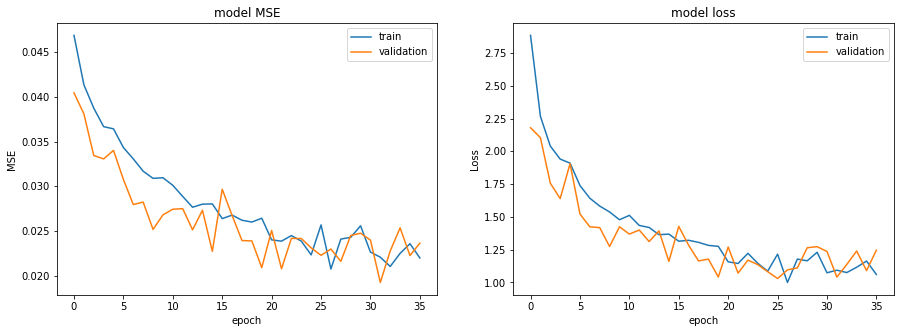

In [52]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15,5))

axs[0].plot(vgg16_history.history['mean_squared_error'])
axs[0].plot(vgg16_history.history['val_mean_squared_error'])
axs[0].set_title('model MSE')
axs[0].set_ylabel('MSE')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'validation'], loc='upper right')

axs[1].plot(vgg16_history.history['loss'])
axs[1].plot(vgg16_history.history['val_loss'])
axs[1].set_title('model loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'validation'], loc='upper right')

# plt.show()

In [55]:
vgg16_preds = model.predict(test_generator)
vgg16_pred_classes = np.argmax(vgg16_preds, axis=1)
print(metrics.classification_report(test_y, vgg16_pred_classes, target_names=classes_label))


35/35 [==============================] - 16s 447ms/step
                               precision    recall  f1-score   support

           005.Crested_Auklet       1.00      1.00      1.00         6
                 013.Bobolink       0.89      0.89      0.89         9
           015.Lazuli_Bunting       1.00      1.00      1.00         8
         023.Brandt_Cormorant       0.75      0.38      0.50         8
   040.Olive_sided_Flycatcher       0.64      0.78      0.70         9
041.Scissor_tailed_Flycatcher       1.00      0.78      0.88         9
         067.Anna_Hummingbird       0.80      0.89      0.84         9
          072.Pomarine_Jaeger       0.67      0.89      0.76         9
          076.Dark_eyed_Junco       0.71      0.56      0.63         9
          081.Pied_Kingfisher       1.00      0.78      0.88         9
        082.Ringed_Kingfisher       0.89      0.89      0.89         9
             086.Pacific_Loon       0.70      0.78      0.74         9
                 099

#### EfficientNetB0

In [56]:
train_datagen_eff = ImageDataGenerator(rotation_range=20, horizontal_flip=True, brightness_range=[0.1, 0.7], fill_mode='nearest', width_shift_range=0.5, preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)
train_generator_eff = train_datagen_eff.flow_from_directory('./output/train', target_size=(224,224), batch_size=5,classes=classes_label, class_mode='categorical', shuffle=True)

valid_datagen_eff = ImageDataGenerator(rotation_range=20, horizontal_flip=True, brightness_range=[0.1, 0.7], fill_mode='nearest', width_shift_range=0.5,preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)
valid_generator_eff = valid_datagen_eff.flow_from_directory('./output/validation',target_size=(224,224),batch_size=5,classes=classes_label,class_mode='categorical',shuffle=False)

test_datagen_eff = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)
test_generator_eff = test_datagen_eff.flow_from_directory('./output/test',target_size=(224,224),batch_size=5,classes=classes_label,class_mode='categorical',shuffle=False)

Found 827 images belonging to 20 classes.
Found 178 images belonging to 20 classes.
Found 171 images belonging to 20 classes.


In [57]:
train_y_eff=train_generator_eff.classes
test_y_eff=test_generator_eff.classes
val_y_eff=valid_generator_eff.classes

In [58]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_shape=(224,224,3), pooling='avg')
for layer in base_model.layers:
    layer.trainable = False
last = base_model.get_layer('avg_pool').output
eff_model = Flatten()(last)
eff_model = Dense(256, activation='relu')(eff_model)
eff_model = Dropout(0.2)(eff_model)
eff_model = tf.keras.layers.BatchNormalization()(eff_model)
eff_model = Dense(20, activation='softmax')(eff_model)
eff_model = tf.keras.Model(base_model.input, eff_model)
opt = keras.optimizers.Adam(learning_rate=0.01)
eff_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc', 'MeanSquaredError'])

number_of_epochs = 60
eff_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=10, restore_best_weights=True)
effB0_history = eff_model.fit(train_generator_eff, 
                          epochs = number_of_epochs ,
                          steps_per_epoch= train_generator_eff.samples/train_generator_eff.batch_size,
                          validation_data = valid_generator_eff,
                          validation_steps= valid_generator_eff.samples/valid_generator_eff.batch_size,
                          callbacks=[eff_early_stopping],
                          verbose=1)


Epoch 1/60
165/165 [==============================] - 45s 202ms/step - loss: 2.1226 - acc: 0.3930 - mean_squared_error: 0.0387 - val_loss: 1.3668 - val_acc: 0.6180 - val_mean_squared_error: 0.0262
Epoch 2/60
165/165 [==============================] - 31s 186ms/step - loss: 1.6169 - acc: 0.5236 - mean_squared_error: 0.0313 - val_loss: 1.1452 - val_acc: 0.6966 - val_mean_squared_error: 0.0218
Epoch 3/60
165/165 [==============================] - 31s 186ms/step - loss: 1.2689 - acc: 0.6070 - mean_squared_error: 0.0259 - val_loss: 1.4832 - val_acc: 0.6742 - val_mean_squared_error: 0.0242
Epoch 4/60
165/165 [==============================] - 31s 187ms/step - loss: 1.3454 - acc: 0.5998 - mean_squared_error: 0.0272 - val_loss: 1.3005 - val_acc: 0.6854 - val_mean_squared_error: 0.0237
Epoch 5/60
165/165 [==============================] - 32s 194ms/step - loss: 1.2913 - acc: 0.6143 - mean_squared_error: 0.0263 - val_loss: 1.3837 - val_acc: 0.7079 - val_mean_squared_error: 0.0218
Epoch 6/60
165/

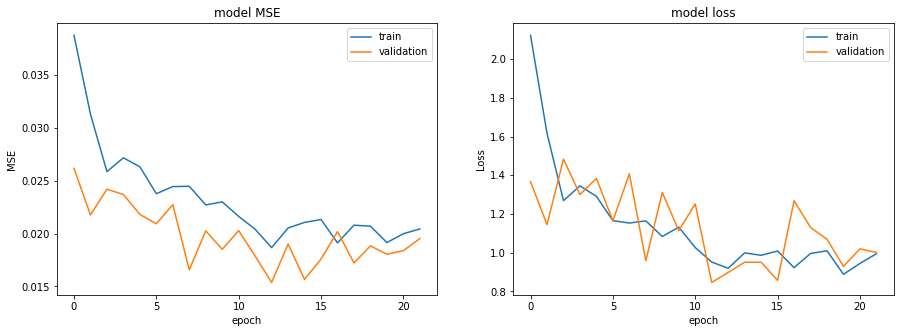

In [59]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15,5))

axs[0].plot(effB0_history.history['mean_squared_error'])
axs[0].plot(effB0_history.history['val_mean_squared_error'])
axs[0].set_title('model MSE')
axs[0].set_ylabel('MSE')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'validation'], loc='upper right')

axs[1].plot(effB0_history.history['loss'])
axs[1].plot(effB0_history.history['val_loss'])
axs[1].set_title('model loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'validation'], loc='upper right')

# plt.plot(effB0_history.history['mean_squared_error'])
# plt.plot(effB0_history.history['val_mean_squared_error'])
# plt.title('model error')
# plt.ylabel('MSE')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

In [60]:
eff_preds = eff_model.predict(test_generator_eff)
eff_pred_classes = np.argmax(eff_preds, axis=1)
print(metrics.classification_report(test_y_eff, eff_pred_classes, target_names=classes_label))

35/35 [==============================] - 8s 160ms/step
                               precision    recall  f1-score   support

           005.Crested_Auklet       1.00      1.00      1.00         6
                 013.Bobolink       1.00      0.89      0.94         9
           015.Lazuli_Bunting       1.00      1.00      1.00         8
         023.Brandt_Cormorant       0.78      0.88      0.82         8
   040.Olive_sided_Flycatcher       0.60      1.00      0.75         9
041.Scissor_tailed_Flycatcher       1.00      0.78      0.88         9
         067.Anna_Hummingbird       1.00      0.78      0.88         9
          072.Pomarine_Jaeger       0.88      0.78      0.82         9
          076.Dark_eyed_Junco       1.00      0.78      0.88         9
          081.Pied_Kingfisher       1.00      0.89      0.94         9
        082.Ringed_Kingfisher       0.90      1.00      0.95         9
             086.Pacific_Loon       0.80      0.89      0.84         9
                 099.

In [61]:
eff_model.save_weights("eff_model.h5")
model.save_weights("model_vgg16.h5")

In [62]:
training_accuracy_vgg = max(vgg16_history.history['acc'])
valindation_accuracy_vgg = max(vgg16_history.history['val_acc'])
test_acc_vgg = 0.77

training_accuracy_eff = max(effB0_history.history['acc'])
valindation_accuracy_eff = max(effB0_history.history['val_acc'])
test_acc_eff = 0.87

print("-------------- VGG16 Results --------------------")
print("Maximum Trainig Accuracy =", training_accuracy_vgg)
print("Maximum validation accuracy = ",valindation_accuracy_vgg)
print("Test Accuracy = ", test_acc_vgg)

print("\n-------------- EfficientNetB0 Results --------------------")
print("Maximum Trainig Accuracy =", training_accuracy_eff)
print("Maximum validation accuracy = ",valindation_accuracy_eff)
print("Test Accuracy = ", test_acc_eff)


-------------- VGG16 Results --------------------
Maximum Trainig Accuracy = 0.7001209259033203
Maximum validation accuracy =  0.7359550595283508
Test Accuracy =  0.77

-------------- EfficientNetB0 Results --------------------
Maximum Trainig Accuracy = 0.7388150095939636
Maximum validation accuracy =  0.7977527976036072
Test Accuracy =  0.87


##### References

* https://www.kaggle.com/code/arjunrao2000/beginners-guide-efficientnet-with-keras
* https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/
* https://medium.com/@mygreatlearning/everything-you-need-to-know-about-vgg16-7315defb5918
* https://www.kaggle.com/questions-and-answers/102677